In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List, Tuple

from IPython.core.display import display, HTML

from datasets import load_metric, load_from_disk, Dataset, DatasetDict, concatenate_datasets

from pororo import Pororo

import logging

logger = logging.getLogger(__name__)


In [2]:
logger = logging.getLogger(__name__)

### 데이터 불러오기

In [5]:
cd ..

/opt/ml


In [6]:
datasets = load_from_disk("./data/train_dataset")

train = datasets['train']
val = datasets['validation']

train_df = pd.DataFrame(train)
val_df = pd.DataFrame(val)

train_question = train_df['question']
val_question = val_df['question']

In [7]:
from pororo import Pororo

ner = Pororo(task="ner", lang="ko")

## raw text -> NER

In [8]:
train_dataset = load_from_disk("./data/train_dataset")['train']

orig_questions = train_dataset['question']

In [9]:
# 속성(attribute)으로 모든 ner을 찾아내야 함 -> 없는 tag 있음
eng_to_kor = {'PERSON' : '사람', 'LOCATION' : '장소', 'ORGANIZATION' : '조직', 'ARTIFACT' : '인공물',
            'DATE' : '날짜', 'TIME' : '시간', 'CIVILIZATION' : '문명', 'ANIMAL' : '동물',
            'PLANT' : '식물', 'QUANTITY' : '수량', 'STUDY_FIELD' : '분야', 'THEORY' : '이론',
            'EVENT' : '사건', 'MATERIAL' : '물질', 'TERM' : '용어',
            'OCCUPATION' : '직업', 'COUNTRY' : '국가', 'CITY' : '도시', 'DISEASE' :'질병'} # 여기서부터 새로 추가한 태그

### 태그 개수 세기

In [10]:
# 태그의 개수 세기 + 태그 전체 들어있는 리스트 만들기
def count_tags(data) :
    NER_sent = []
    cnt_tag = []
    for item in data :
        res = ''
        cnt = 0
        ner_item = ner(item)
        for word in ner_item :
            if word[1] != 'O' :
                res += f'({eng_to_kor[word[1]]}) {word[0]}'
                cnt += 1
            else :
                res += word[0]              
        NER_sent.append(res)
        cnt_tag.append(cnt)      
    return NER_sent, cnt_tag

In [11]:
NER_qst, qst_cnt_tags = count_tags(train_question)

In [12]:
NER_qst

['(문명) 대통령을 포함한 (국가) 미국의 (조직) 행정부 견제권을 갖는 국가 기관은?',
 '현대적 인사조직관리의 시발점이 된 책은?',
 '(사람) 강희제가 (날짜) 1717년에 쓴 글은 누구를 위해 쓰여졌는가?',
 '(날짜) 11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?',
 '명문이 적힌 유물을 구성하는 그릇의 총 개수는?',
 '(사람) 카드모스의 (문명) 부하들이 간 곳에는 무엇이 있었는가?',
 '(사람) 관우를 불태워 죽이려한 사람 누구인가?',
 '참호 속에 무기와 장비를 버리고 도주한 집단은?',
 '(수량) 제2차 (사건) 세계 대전에 참전하여 사망한 (문명) 자식은?',
 '(날짜) 고려 (사람) 공민왕이 (문명) 처가 (문명) 식구들과 (문명) 아내와 함께 피신처로 삼은 마을은?',
 '(사람) 정여창은 어떻게 죽었나?',
 '(사람) 아멜리아는 (사람) 빅토르의 직업을 무엇으로 착각하나요?',
 '(문명) 우핑가스 왕조의 이름은 어디서 유래하였나?',
 '장면이 (국가) 한국으로 돌아온 년도는?',
 '(조직) 유대교의 지나친 차별을 타파하려한 사람은?',
 '권번에서 요릿집에 제공한 (문명) 기생 명부의 이름은?',
 '(조직) 영국군 (수량) 약 42만명의 (문명) 사상자가 발생한 전투가 시작된 연도는?',
 '(사람) 웨이크필드가 (수량) 15번째 시즌에 활약한 팀의 이름은?',
 '(사람) 김상옥이 (조직) 종로경찰서에 (인공물) 폭탄을 던진 직후 피신한 곳은?',
 '(사람) 윤치호가 극찬했던 (날짜) 조선시대의 인물은 누구인가요?',
 '(사람) 항우가 (장소) 진나라를 멸하면서 (문명) 조왕 (사람) 헐은 어디로 이동했는가?',
 '(날짜) 30일에 (날짜) 한달 연장 근무를 신청하는 (문명) 병사가 상금으로 받게 되는 금액은?',
 '(사람) 슈만이 (조직) 미군에게 (문명) 포로로 잡혔던 년도는?',
 '(사람) 김건의 (문명) 할아버지가 세운 학교는?',
 '(용어) 뇌에 탈피 신호를 보내

In [13]:
print(qst_cnt_tags[:10])

[3, 0, 2, 1, 0, 2, 1, 0, 3, 5]


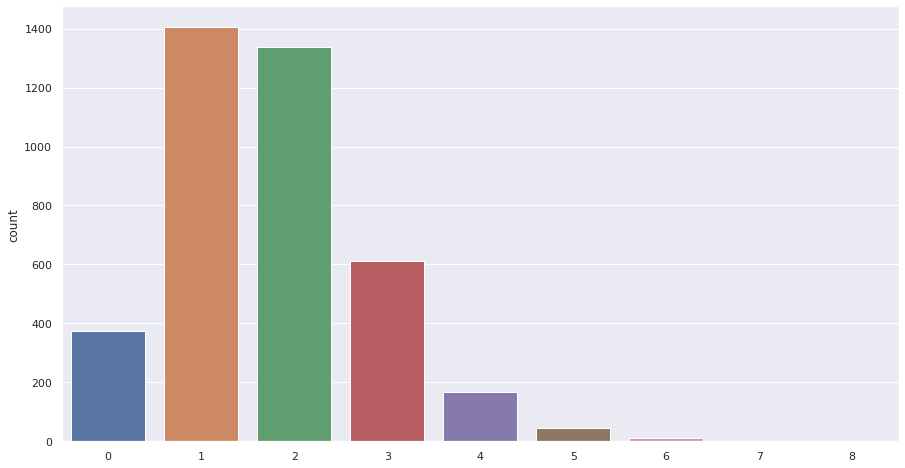

In [14]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x=qst_cnt_tags)
plt.show()

한 질문 당 붙여진 태그가 2개 이하인 경우가 가장 많으므로

2개 이상의 태그를 가진 질문 -> 2개의 태그를 랜덤하게 붙여주기
2개 이하의 태그를 가진 질문 -> 그대로 붙여주기

### 최대 2개의 태그만 랜덤으로 붙여주기

In [20]:
def random_aug(
    ner_sent:List[Tuple[str, str]],
    has_tag:List[bool],
    max_tag_num:int = 2) -> str:

    tag_num = sum(has_tag)  # total num of tags
    
    if tag_num > max_tag_num:
        has_tag = np.array(has_tag)
        tag_pos_idx = np.where(has_tag)

        # leave only max_tag_num positions to True
        set_false_pos = np.random.choice(tag_pos_idx[0], tag_num - max_tag_num, replace=False)
        has_tag[set_false_pos] = False

    aug_sentence = ''
    # create a new sentence with tags inserted
    for item, add_tag in zip(ner_sent, has_tag):
        if add_tag and item[1] != 'O':
            aug_sentence += f'{eng_to_kor[item[1]]} '
        aug_sentence += item[0]      
    return aug_sentence


def add_ner_tag(example):
    question = example["question"]
    
    ner_question = ner(question)  # list of (word, tag)

    # 'O': not considered as a tag
    tag_pos = [False if word[1] == 'O' else True for word in ner_question]
    
    # return {'question': random_aug(ner_question, tag_pos, max_tag_num=2)}
    example["question"] = random_aug(ner_question, tag_pos, max_tag_num=2)
    return example


In [22]:
datasets = load_from_disk("/opt/ml/data/train_dataset")
train_dataset = datasets["train"]

datasets_aug = load_from_disk("/opt/ml/data/train_dataset")
train_dataset_aug = datasets_aug["train"]

In [23]:
df_train_aug = train_dataset_aug.to_pandas() 
df_train = train_dataset.to_pandas()
df_concat = pd.concat((df_train, df_train_aug))

In [24]:
df_concat = df_concat.drop_duplicates(subset=['question', 'context'], keep='first')
df_final = df_concat.drop(columns=["__index_level_0__"], axis=1)
logger.info('drop duplicates of ["question", "context"]')


In [25]:

dataset_final = Dataset.from_pandas(df_final)
logger.info(f'created Dataset of size {len(dataset_final)}')

datasets["train"] = dataset_final
datasets.save_to_disk("/opt/ml/data/ner_train_dataset")


## 실험 1 - 단어 단위로 잘라서 ner 태깅

In [9]:
from konlpy.tag import Okt

okt = Okt()

In [27]:
test_nouns = []
for item in train_question :
    test_nouns.extend(okt.nouns(item))

In [30]:
cnt = 0
for word in test_nouns :
    res = ner(word)
    if res[0][1] != 'O' :
        cnt += 1

In [34]:
print(f'Default tags : {sum(qst_cnt_tags)}    Word split tags : {cnt}')

Default tags : 6885    Word split tags : 7045


text를 그대로 ner 태깅하는 것과 명사만을 추출해서 태깅하는 것은 거의 비슷한 태그 수를 가진다.

## 실험 2 - 형태소 단위로 잘라서 ner 태깅

In [10]:
test_morphs = []
for item in train_question :
    test_morphs.extend(okt.morphs(item))

In [13]:
if '' in test_morphs :
    print("7")

In [16]:
cnt2 = 0
for word in test_morphs :
    try :
        res = ner(word)
        if res[0][1] != 'O' :
            cnt2 += 1
    except :
        print(word)

《
》
《
》
《
》
《
》
《
》
(
『
』
《
》
《
》
《
》
《
》
《
》
《
》
《
》
《
》
《
》
《
》
「
」
《
》
《
》
〈
〉
《
》
(
(
)
(
)
『
』
《
》
《
》
《
》
(
)
《
》
《
》
(
)
《
》
《
》
《
》
《
》
《
》


》《 〈 〉(『 』 등의 특수기호가 ner() 에 들어가면 error -> 그래도 결국 'O'로 태깅이 될테니 넘어가도 괜찮다

In [19]:
print(f'Default tags : 6885    Morph split tags : {cnt2}')

Default tags : 6885    Morph split tags : 10190


확실히 형태소 단위로 태깅하면 태그의 수가 더 많이 나오지만 '~~은' 이 MATERIAL로 태깅되는 등의 문제가 있다.